## Knowledge Backpropagation - Running Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import logging

import dataset
import dataset_misc1d
import dataset_misc2d
import dataset_physics
import space
from symbols.const import ConstantSyntaxTree
from symbols.var import VariableSyntaxTree
from symbols.binop import BinaryOperatorSyntaxTree
from symbols.unaop import UnaryOperatorSyntaxTree
from gp import creator, corrector as gp_corrector
from backprop import library
import randstate

SAMPLE_SIZE = 100
NOISE = 0.0#5
MESH_SIZE   = 100

MAX_STREE_DEPTH  = 8
MAX_STREE_LENGTH = 25

LIBSIZE       = 2000
LIB_MAXDEPTH  = 5
LIB_MAXLENGTH = 15

RANDSTATE = 1234

In [2]:
randstate.setstate(RANDSTATE)

S = dataset_misc1d.MagmanDatasetScaled()
#S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
S.load('../data/magman.csv')
S.split()

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [3]:
np.seterr(all='ignore')

backprop_node = ConstantSyntaxTree(2.0)
stree = BinaryOperatorSyntaxTree('/',
        BinaryOperatorSyntaxTree('*',  # +
            ConstantSyntaxTree(-0.05),
            VariableSyntaxTree(),
        ),
        UnaryOperatorSyntaxTree('cube', backprop_node)
    )

solutionCreator = creator.PTC2RandomSolutionCreator(nvars=S.nvars, const_prob=0.5)

mesh = space.MeshSpace(S_train, S.knowledge, MESH_SIZE)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, MAX_STREE_LENGTH, mesh, LIBSIZE, LIB_MAXDEPTH, LIB_MAXLENGTH, solutionCreator)

In [4]:
new_stree, new_node, C_pulled, y_pulled = corrector.correct(stree, backprop_node, relax=False)

S_backprop = dataset.NumpyDataset(S)
S_backprop.X = S_train.X
S_backprop.y = y_pulled

<!--![title](../figs/meeting/running-example.png)

 h(x) = square((square(x0) + 0.20))

Subject to:
 h(x) ≠ 0
 h(x) ≥ 0  [-2.00,2.00]
∂h(x) ≤ 0  [-2.00,-0.34]
∂h(x) ≥ 0  [0.34,2.00]



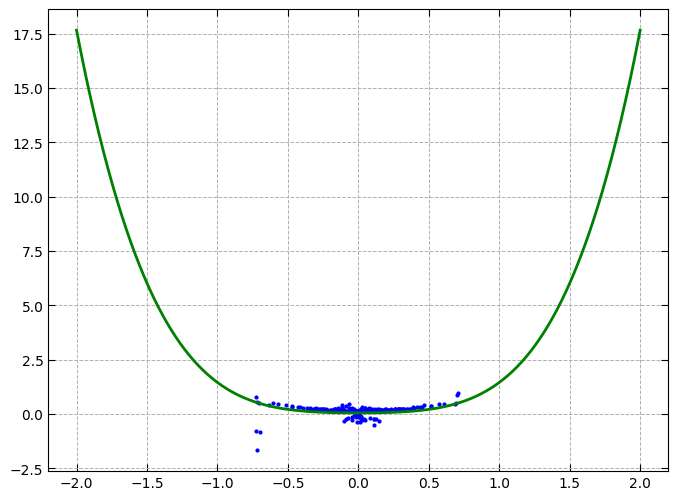

In [5]:
if new_node is None: print(f" h(x) = None (Could not find a function in the library)")
else: print(f" h(x) = {new_node}")
print(f"\nSubject to:\n{C_pulled.format(mesh.X, funcname='h')}")
S_backprop.get_plotter().plot(width=8, height=6, model=new_node)